## Dog Breed Classification

In this project we will use traditional CNN, CNN with data augmentation and finally transfer Learning by VGG16 model with weights pre-trained on Imagenet to solve the dog breed classification problem

### Load Dataset Files

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Importing necessary libraries.
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


Now, upload the given dataset file shared with you in your google drive and give its path for the below given `project_path` variable. For example, a path is given below according to the file path in our google drive. You need to change this to match the path of yours.

In [0]:
project_path = "/content/drive/My Drive/DogBreed_Classification/"

Run the below code to extract all the images in the train.zip files given in the dataset. We are going to use these images as train and validation sets and their labels in further steps.

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'train.zip', 'r') as z:
  z.extractall()

Repeat the same step for test.zip

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'test.zip', 'r') as z:
  z.extractall()

Repeat the same step for sample_submission.csv.zip

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'sample_submission.csv.zip', 'r') as z:
  z.extractall()

Repeat the same step for labels.csv.zip

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'labels.csv.zip', 'r') as z:
  z.extractall()

After this process, we will have 4 files - Train folder, test folder and labels.csv and sample_submission.csv as part of your google drive

### Read labels.csv file using pandas

In [0]:
import tensorflow as tf
import pandas as pd

labels=pd.read_csv('labels.csv')

In [0]:
test=pd.read_csv('sample_submission.csv')

### Print the count of each category of Dogs given in the dataset



In [10]:
breed_count = labels['breed'].value_counts()

print("Breed Count :",breed_count.head())
print("Shape of Dataset :",breed_count.shape)

Breed Count : scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64
Shape of Dataset : (120,)


### Get one-hot encodings of labels

In [0]:
targets        = pd.Series(labels['breed'])
one_hot        = pd.get_dummies(targets, sparse = True)
one_hot_labels = np.asarray(one_hot)

## Preparing training dataset
1. Write a code which reads each and every id from labels.csv file and loads the corresponding image (in RGB - 128, 128, 3) from the train folder. <br>
2. Create 2 variables <br> 
     a.  x_train - Should have all the images of the dogs from train folder <br>
     b.  y_train - Corresponding label of the dog <br>
<u>Note:</u> The id of the dog images and its corresponding labels are available in labels.csv file   
<u>Hint:</u> Watch the video shared on "Preparing the training dataset" if you face issue on creating the training dataset

In [12]:
from tqdm import tqdm
import cv2
x_train_features = []
y_train_features = []
y_train_labels = []
i = 0 

for f, img in tqdm(labels.values):
  train_img = cv2.imread('./train/{}.jpg'.format(f),1)
  train_img_resize = cv2.resize(train_img, (128,128))
  label = one_hot_labels[i]
  x_train_features.append(train_img_resize)
  y_train_features.append(img)
  y_train_labels.append(label)
  i = i+1

100%|██████████| 10222/10222 [00:26<00:00, 381.04it/s]


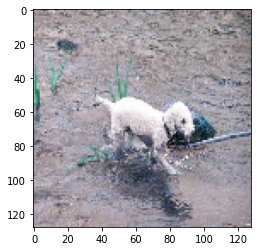

In [13]:
import matplotlib.pyplot as plt
plt.imshow(x_train_features[5])

Normalize the training data and convert into 4 dimensions so that it can be used as an input to conv layers in the model

In [0]:
#Normalizing the training data....
X_train = np.array(x_train_features, np.float32) / 255

Y_train = np.array(y_train_labels, np.uint8)

In [0]:
X_train = X_train.reshape(X_train.shape[0],128,128,3)

### Split the training and validation data from `x_train_data` and `y_train_data` obtained from above step

In [0]:
from keras.layers import Dense,Dropout,Flatten
from sklearn.model_selection import train_test_split as tts
x_train,x_test,y_train, y_test= tts(X_train,Y_train,train_size=0.2)

### Loading the test data
Read the id column from the samples_submission.csv and store it in test_img

In [17]:
test_img =test['id']
test_img.shape

(10357,)

Run the below code to load the test image files in x_test_feature

In [18]:
from tqdm import tqdm
x_test_features = []
i = 0 # initialisation.

for f in tqdm(test_img.values): # f for format ,jpg.
    img = cv2.imread('./test/{}.jpg'.format(f), 0)
    img_resize = cv2.resize(img, (test_img.shape[0], 1)) 
    x_test_features.append(img_resize)

100%|██████████| 10357/10357 [00:14<00:00, 716.18it/s]


Normalize the test data and convert it into 4 dimensions

### Build a basic conv neural network with 2 conv layers (kernel sizes - 5 and 3) add layers as mentioned below for classification.

1. Add a Dense layer with 256 neurons with `relu` activation

2. Add a Dense layer with 120 neurons as final layer (as there are 120 classes in the given dataset) with `softmax` activation for classifiaction. 

In [0]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras.models import Sequential       
from keras.layers import Conv2D, MaxPool2D

model = Sequential()

# Adding two conv layers..
model.add(Conv2D(32, kernel_size=(5, 3), activation='relu', input_shape=(128,128,3)))

model.add(Conv2D(32, kernel_size=(5, 3), activation='relu', input_shape=(128,128,3)))

# Flatten.
model.add(Flatten())

# Adding Dense Layers..
model.add(Dense(256, activation='relu'))

model.add(Dense(120, activation='softmax'))

# Compiling the model using Adam optimizer and categorical_crossentropy loss....
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

### Use batch_size = 128 and epochs = 10 and execute the model

In [20]:
history=model.fit(X_train, Y_train, batch_size=128, epochs=10)

Epoch 1/10
10222/10222 [==============================] - 28s 3ms/step - loss: 5.2035 - accuracy: 0.0088
Epoch 2/10
10222/10222 [==============================] - 21s 2ms/step - loss: 4.7778 - accuracy: 0.0131
Epoch 3/10
10222/10222 [==============================] - 21s 2ms/step - loss: 4.4565 - accuracy: 0.0862
Epoch 4/10
10222/10222 [==============================] - 21s 2ms/step - loss: 2.5344 - accuracy: 0.4352
Epoch 5/10
10222/10222 [==============================] - 21s 2ms/step - loss: 0.5484 - accuracy: 0.8867
Epoch 6/10
10222/10222 [==============================] - 21s 2ms/step - loss: 0.1244 - accuracy: 0.9846
Epoch 7/10
10222/10222 [==============================] - 21s 2ms/step - loss: 0.0462 - accuracy: 0.9949
Epoch 8/10
10222/10222 [==============================] - 21s 2ms/step - loss: 0.0265 - accuracy: 0.9975
Epoch 9/10
10222/10222 [==============================] - 21s 2ms/step - loss: 0.0218 - accuracy: 0.9986
Epoch 10/10
10222/10222 [==============================

# Accuracy is almost 99%.

#The model accuracy is very poor !!!!

### Use Data Augmentation in the above model to see if the accuracy improves


In [0]:
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(rotation_range=45,
                             rescale=1/255,
                             width_shift_range=0.2, 
                             height_shift_range=0.2)

datagen.fit(X_train)

### Using the above objects, create the image generators with variable names `train_generator` and `val_generator`

You need to use train_datagen.flow() and val_datagen.flow()

In [0]:
train_datagen = datagen.flow(X_train, Y_train, shuffle=False)
val_datagen = datagen.flow(x_test, y_test, shuffle=False)

### Fit the model using fit_generator() using `train_generator` and `val_generator` from the above step with 10 epochs

In [23]:
# # fits the model on batches with real-time data augmentation:
history = model.fit_generator(train_datagen,
                    steps_per_epoch=len(X_train) / 32, epochs = 10)

Epoch 1/10
320/319 [==============================] - 55s 173ms/step - loss: 4.9006 - accuracy: 0.0109
Epoch 2/10
320/319 [==============================] - 55s 172ms/step - loss: 4.7799 - accuracy: 0.0114
Epoch 3/10
320/319 [==============================] - 55s 172ms/step - loss: 4.7789 - accuracy: 0.0123
Epoch 4/10
320/319 [==============================] - 55s 173ms/step - loss: 4.7786 - accuracy: 0.0111
Epoch 5/10
320/319 [==============================] - 56s 174ms/step - loss: 4.7785 - accuracy: 0.0123
Epoch 6/10
320/319 [==============================] - 56s 175ms/step - loss: 4.7784 - accuracy: 0.0123
Epoch 7/10
320/319 [==============================] - 56s 174ms/step - loss: 4.7784 - accuracy: 0.0118
Epoch 8/10
320/319 [==============================] - 56s 174ms/step - loss: 4.7782 - accuracy: 0.0123
Epoch 9/10
320/319 [==============================] - 56s 174ms/step - loss: 4.7780 - accuracy: 0.0123
Epoch 10/10
320/319 [==============================] - 56s 174ms/step - l

# Model accuracy is still poor!!!

### Lets use Transfer Learning

Download the vgg wieght file from here : https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

Use the below code to load VGG16 weights trained on ImageNet

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input

import h5py

# Instantiate the model with the pre-trained weights (no top)

base_model= VGG16(weights='/content/drive/My Drive/Colab Notebooks/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                  include_top=False, pooling='avg')

Print the summary of the base_model

In [25]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### Add the following classification layers to the imported VGG Model <br>
1. Flatten Layer
2. Dense layer with 1024 neurons with activation as Relu
3. Dense layer with 256 neurons with activation as Relu
4. Dense layer with 120 neurons with activation as Softmax

In [0]:
new_model = base_model

new_model.layers.append(Flatten())

new_model.layers.append(Dense(1024,activation='relu'))

new_model.layers.append(Dense(256,activation='relu'))

new_model.layers.append(Dense(120,activation='softmax'))

### Make all the layers in the base_model (VGG16) to be non-trainable

In [0]:
# Making all layers in base model to be non-trainable.
for layer in new_model.layers:
    layer.trainable = False

### Fit and compile the model with batch_size = 128 and epochs = 10 and execute the model

Try to get training and validation accuracy to be more than 90%

In [0]:
new_model.compile(loss = "categorical_crossentropy", optimizer = 'SGD', metrics=["accuracy"])

In [29]:
new_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

RuntimeError: ignored

In [0]:
new_model.fit(x_train, y_train, batch_size=128, 
                  validation_data=(x_val, y_val), epochs=10)